# Exercise 5, problem 1

## Visualize a static map

We are going to make a map that tells us how many people live in 500 m from Helsinki and Vantaa railwaystations.

First, we load the population data.

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
from pyproj import CRS
from shapely.geometry import Point
import requests
import geojson
import matplotlib.pyplot as plt
import contextily as ctx

url = 'https://kartta.hsy.fi/geoserver/wfs'

params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

r = requests.get(url, params=params)
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))


In [2]:
pop.head()

,geometry,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80
0,MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...,3342,108,45,11,23,6,7,26,17,8,6,4
1,MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...,3503,273,35,35,24,52,62,40,26,25,9,0
2,MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...,3660,239,34,46,24,24,45,33,30,25,10,2
3,MULTIPOLYGON Z (((25476999.994 6675499.004 0.0...,3661,202,30,52,37,13,36,43,11,4,3,3
4,MULTIPOLYGON Z (((25476999.994 6675249.005 0.0...,3662,261,30,64,32,36,64,34,20,6,3,2


Let's keep only necessary columns.

In [3]:
pop = pop[['geometry', 'asukkaita']]
pop.head()

,geometry,asukkaita
0,MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...,108
1,MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...,273
2,MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...,239
3,MULTIPOLYGON Z (((25476999.994 6675499.004 0.0...,202
4,MULTIPOLYGON Z (((25476999.994 6675249.005 0.0...,261


Next, we load a text file that contains almost all railwaystations in Helsinki and Vantaa. Two stations, Helsinki-Vantaa airport and Aviapolis, are left out since there are very few people living near them.

In [4]:
fp = r"data/asemat2.txt"

stations = pd.read_csv(fp, sep=';')

In [5]:
stations.head()

,id,addr
0,Helsinki,"Elielinaukio 3, 00100 Helsinki, Finland"
1,Pasila,"rautatieasema pasila, 00520 Helsinki, Finland"
2,Käpylä,"rautatieasema käpylä, 00620 Helsinki, Finland"
3,Oulunkylä,"rautatieasema oulunkylä, 00640 Helsinki, Finland"
4,Pukinmäki,"rautatieasema pukinmäki, 00720 Helsinki, Finland"


Now we geocode those stations and join the result with stations-dataframe.

In [6]:
geo = geocode(stations['addr'], provider='nominatim', user_agent='autogis_5', timeout=4)
geo.head()

,geometry,address
0,POINT (24.93955 60.17172),"Elielinaukio, Keskusta, Kluuvi, Eteläinen suur..."
1,POINT (24.93348 60.19866),"Pasila, Pasilan asema-aukio, Keski-Pasila, Pas..."
2,POINT (24.94661 60.22018),"Käpylä, Käpylän asemaraitti, Metsälä, Käpylä, ..."
3,POINT (24.96648 60.22810),"Oulunkylä, Oulunkylänpolku, Veräjämäki, Oulunk..."
4,POINT (24.99382 60.24223),"Pukinmäki, Kehä I, Ala-Malmi, Pukinmäki, Helsi..."


In [7]:
join = geo.join(stations)
join.head()

,geometry,address,id,addr
0,POINT (24.93955 60.17172),"Elielinaukio, Keskusta, Kluuvi, Eteläinen suur...",Helsinki,"Elielinaukio 3, 00100 Helsinki, Finland"
1,POINT (24.93348 60.19866),"Pasila, Pasilan asema-aukio, Keski-Pasila, Pas...",Pasila,"rautatieasema pasila, 00520 Helsinki, Finland"
2,POINT (24.94661 60.22018),"Käpylä, Käpylän asemaraitti, Metsälä, Käpylä, ...",Käpylä,"rautatieasema käpylä, 00620 Helsinki, Finland"
3,POINT (24.96648 60.22810),"Oulunkylä, Oulunkylänpolku, Veräjämäki, Oulunk...",Oulunkylä,"rautatieasema oulunkylä, 00640 Helsinki, Finland"
4,POINT (24.99382 60.24223),"Pukinmäki, Kehä I, Ala-Malmi, Pukinmäki, Helsi...",Pukinmäki,"rautatieasema pukinmäki, 00720 Helsinki, Finland"


We have now two geodataframes and we have to make sure that they are in the same coordinate system.

In [8]:
print(join.crs)

EPSG:4326


In [9]:
print(pop.crs)

None


In [10]:
pop.crs = CRS.from_epsg(3879).to_wkt()
pop.crs

<Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - 24.5°E to 25.5°E onshore nominal
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
join = join.to_crs(pop.crs)
join.crs

<Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - 24.5°E to 25.5°E onshore nominal
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Next we will proceed by making 500 m buffers around stations.

In [12]:
join = join[['id', 'geometry']]
join['buffer'] = join['geometry'].apply(lambda p: p.buffer(500))

In [13]:
join.head()

,id,geometry,buffer
0,Helsinki,POINT (25496644.640 6673206.841),"POLYGON ((25497144.640 6673206.841, 25497142.2..."
1,Pasila,POINT (25496310.589 6676208.479),"POLYGON ((25496810.589 6676208.479, 25496808.1..."
2,Käpylä,POINT (25497040.795 6678605.463),"POLYGON ((25497540.795 6678605.463, 25497538.3..."
3,Oulunkylä,POINT (25498142.236 6679486.419),"POLYGON ((25498642.236 6679486.419, 25498639.8..."
4,Pukinmäki,POINT (25499657.874 6681060.943),"POLYGON ((25500157.874 6681060.943, 25500155.4..."


Let's make a separate geodataframe for buffers.

In [14]:
areas = gpd.GeoDataFrame(join['id'], geometry = join['buffer'], crs='EPSG:3879')
areas.head()

,id,geometry
0,Helsinki,"POLYGON ((25497144.640 6673206.841, 25497142.2..."
1,Pasila,"POLYGON ((25496810.589 6676208.479, 25496808.1..."
2,Käpylä,"POLYGON ((25497540.795 6678605.463, 25497538.3..."
3,Oulunkylä,"POLYGON ((25498642.236 6679486.419, 25498639.8..."
4,Pukinmäki,"POLYGON ((25500157.874 6681060.943, 25500155.4..."


Next task is to select only those rows from the population data that intersect with our buffers.

In [15]:
areas_pop = gpd.overlay(pop, areas, how='intersection')

In [16]:
areas_pop.head()

,asukkaita,id,geometry
0,657,Martinlaakso,"POLYGON Z ((25491499.998 6685418.241 0.000, 25..."
1,461,Martinlaakso,"POLYGON Z ((25491388.514 6685249.001 0.000, 25..."
2,181,Martinlaakso,"POLYGON Z ((25491357.455 6684999.002 0.000, 25..."
3,110,Martinlaakso,"POLYGON Z ((25491464.484 6684749.002 0.000, 25..."
4,686,Martinlaakso,"POLYGON Z ((25491499.998 6685249.001 0.000, 25..."


<AxesSubplot:>

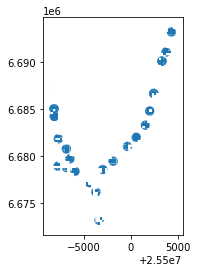

In [17]:
areas_pop.plot()

The finishing touch is to combine all rows by station.

In [18]:
final_areas = areas_pop.dissolve(by='id', aggfunc='sum')
final_areas.head()

,geometry,asukkaita
id,,
Helsinki,MULTIPOLYGON Z (((25496749.998 6672749.004 0.0...,4553
Hiekkaharju,"POLYGON Z ((25502249.995 6686499.006 0.000, 25...",5498
Huopalahti,"POLYGON Z ((25493999.999 6677906.992 0.000, 25...",7021
Ilmala,"POLYGON Z ((25495499.993 6676721.337 0.000, 25...",2197
Kannelmäki,"POLYGON Z ((25493572.454 6680498.997 0.000, 25...",10899


<AxesSubplot:>

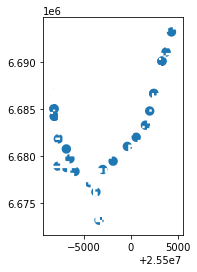

In [19]:
final_areas.plot()

Before we can plot our areas and stations, we have to re-project them to EPSG:3857, because this the coordinate system that our basemap will use.

In [20]:
final_areas = final_areas.to_crs(epsg=3857)
geo = geo.to_crs(epsg=3857)
print(final_areas.crs)
print(geo.crs)

epsg:3857
epsg:3857


Now we can plot stations and population buffers on map.

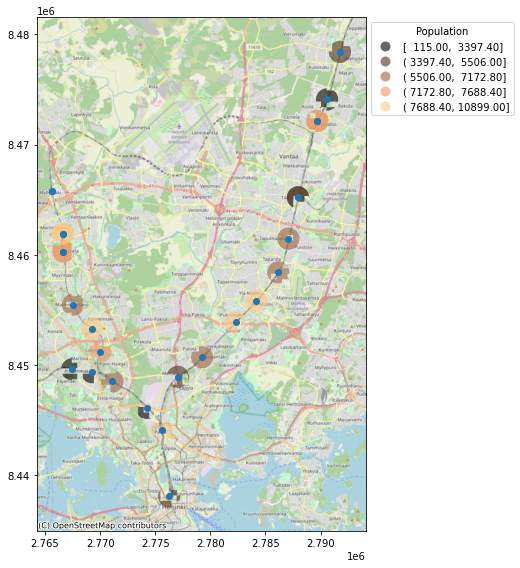

In [35]:
fig, ax = plt.subplots(figsize=(12,8))

final_areas.plot(ax=ax, column='asukkaita', cmap='copper', linewidth=0, scheme="quantiles", k=5, alpha=0.6, legend=True)
ax.get_legend().set_bbox_to_anchor((1,1))
ax.get_legend().set_title('Population')

geo.plot(ax=ax)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.tight_layout()

outfp = 'docs/stations_pop.png'
plt.savefig(outfp, dpi=300)